# Релиз 2.0 Обработка данных

In [2]:
import pandas as pd
import numpy as np 
import re

Считываем CSV файл и отображаем все колонки DataFrame.

In [3]:
df=pd.read_csv('~/real_estate/data/_data.csv', index_col=0)
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_colwidth')
pd.set_option('display.float_format', '{:.2f}'.format)


Удаляем все адреса не относящиеся к москве.

In [4]:
df0=df[df['Адрес'].str.contains('Москва', case=False)].copy()

Разделение столбца "Цена" на категории.

In [5]:
df1 = df0.copy()
df1['Цена'] = df1['Цена'].transform(lambda x: x.split(','))
df1['price'] = df1['Цена'].transform(lambda x: next((i for i in x if 'месяц' in i), np.nan))
df1['utility_payments'] = df1['Цена'].transform(lambda x: next((i for i in x if 'Сумма' in i), np.nan))
df1['deposit'] = df1['Цена'].transform(lambda x: next((i for i in x if 'Залог' in i), np.nan))
df1['public_utilities'] = df1['Цена'].transform(lambda x: next((i for i in x if 'Коммунальные' in i), np.nan))
df1['lease_term'] = df1['Цена'].transform(lambda x: next((i for i in x if 'Срок' in i), np.nan))
df1['prepayment'] = df1['Цена'].transform(lambda x: next((i for i in x if 'Предоплата' in i), np.nan))


Конвертируем валюты и преобразуем в числовой тип

In [6]:
def convert_currency(price_str):

    price_str = str(price_str).lower()
    if '$' in price_str in price_str:
        return 82
    elif '€' in price_str in price_str:
        return 93
    return 1


df1['price'] = (
    df1['price'].str.extract(r'([\d\s,]+\.?\d*)')[0] 
    .apply(pd.to_numeric, errors='coerce')
    * df1['price'].apply(convert_currency)  
)

Разделение столбца "Метро" на категории.

In [7]:
extracted = df1['Метро'].str.extract(r'(\d+)\sмин\s(пешком|на машине)')     # изменила время метро, учитывает, на машине 
extracted.columns = ['minutes', 'transport']
df1['time_metro'] = extracted.apply(
    lambda row: int(row['minutes']) * 3 if row['transport'] == 'на машине' 
    else int(row['minutes']) if pd.notna(row['minutes']) 
    else np.nan,
    axis=1)
df1['metro'] = df1['Метро'].transform(lambda x: x.split('(')[0].strip() if pd.notna(x) else np.nan)


Форматирование столбца "Площадь, м2" и приведение к общей площади, так как остальные данные невозможно идентифицировать.

In [8]:
df1['total_area'] = pd.to_numeric(df1['Площадь, м2'].str.extract(r'(\d+\.\d+)')[0])

Разделение столбца "Дом" на категории

In [9]:
df1['floor'] = df1['Дом'].transform(lambda x: x.split(',')[0].split('/')[0])
df1['all_floor'] = df1['Дом'].transform(lambda x: x.split(',')[0].split('/')[1])
df1['house'] = df1['Дом'].transform(       # изменила тут при преобразоании вначале был пробел
    lambda x: x.split(',')[1].strip() if len(x.split(',')) > 1 else np.nan
)
df1['floor'] = pd.to_numeric(df1['floor'], errors='coerce')
df1['all_floor'] = pd.to_numeric(df1['all_floor'], errors='coerce')

Приведение колонки "Количество комнат" к числовому значению и удаление неинформативного материала.

In [10]:
df1['rooms'] = pd.to_numeric(df1['Количество комнат'].str.extract(r'(\d+)')[0], errors='coerce')

Приводим колонку время до метро к числовому значению

In [11]:
df1['time_metro'] = pd.to_numeric(df1['time_metro'], errors='coerce')

Удаление всех столбцов повторяющих данные, не несущих информативносли или же не идентифицириумых.

In [12]:
df1.drop(columns= ['Название ЖК', 'Дом', 'Дополнительно', 'prepayment', 'utility_payments', 'lease_term', 'deposit', 'public_utilities', 'Количество комнат', 'Площадь, м2', 'Описание','Площадь комнат, м2', 'Мусоропровод', 'Метро', 'Высота потолков, м', 'Телефоны','Серия дома', 'Ссылка на объявление', 'Тип', 'Адрес', 'Цена'], inplace=True)
df1.head()

,ID объявления,Парковка,Ремонт,Балкон,Окна,Санузел,Можно с детьми/животными,Лифт,price,time_metro,metro,total_area,floor,all_floor,house,rooms
0,271271157,подземная,Дизайнерский,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Пасс (4), Груз (1)",500000.00,9.00,м. Смоленская,200.00,5,16,Монолитный,4.00
1,271634126,подземная,Дизайнерский,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Пасс (1), Груз (1)",500000.00,8.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00
2,271173086,подземная,Евроремонт,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,Пасс (1),500000.00,7.00,м. Смоленская,200.00,5,16,NaN,4.00
3,272197456,подземная,Евроремонт,NaN,На улицу и двор,Совмещенный (3),Можно с животными,Пасс (1),400000.00,3.00,м. Смоленская,170.00,5,6,NaN,4.00
4,273614615,NaN,Евроремонт,NaN,На улицу и двор,Совмещенный (2),NaN,"Пасс (1), Груз (1)",225000.00,7.00,м. Арбатская,58.00,12,26,Панельный,2.00


Переименовываем столбцы по стандарту 


In [13]:
column_rename = {
    'ID  объявления': 'ID',
    'Парковка': 'parking',
    'Ремонт': 'renovation',
    'Балкон': 'balcony',
    'Окна': 'windows',
    'Санузел': 'bathroom',
    'Можно с детьми/животными': 'children_pets_allowed',
    'Лифт': 'elevator',
}
df1 = df1.rename(columns=column_rename)
df1.head()

,ID,parking,renovation,balcony,windows,bathroom,children_pets_allowed,elevator,price,time_metro,metro,total_area,floor,all_floor,house,rooms
0,271271157,подземная,Дизайнерский,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Пасс (4), Груз (1)",500000.00,9.00,м. Смоленская,200.00,5,16,Монолитный,4.00
1,271634126,подземная,Дизайнерский,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Пасс (1), Груз (1)",500000.00,8.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00
2,271173086,подземная,Евроремонт,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,Пасс (1),500000.00,7.00,м. Смоленская,200.00,5,16,NaN,4.00
3,272197456,подземная,Евроремонт,NaN,На улицу и двор,Совмещенный (3),Можно с животными,Пасс (1),400000.00,3.00,м. Смоленская,170.00,5,6,NaN,4.00
4,273614615,NaN,Евроремонт,NaN,На улицу и двор,Совмещенный (2),NaN,"Пасс (1), Груз (1)",225000.00,7.00,м. Арбатская,58.00,12,26,Панельный,2.00


Работаем с NaN значениями

In [14]:
df1.isna().sum().to_frame()


,0
ID,0
parking,11174
renovation,2463
balcony,6630
windows,5150
bathroom,2041
children_pets_allowed,4915
elevator,4192
price,0
time_metro,884


NaN в количествах комнат заменяет на 0, так как это студия (проаналировали несколько ссылок в датасете)

In [15]:
df1['rooms'] = df1['rooms'].fillna(0)
df1['rooms'].value_counts()

rooms
2.00    7407
1.00    6655
3.00    3668
4.00    1011
0.00     535
5.00     333
6.00     128
Name: count, dtype: int64

NaN в балконах, парковках и лифтах заменяем на 'отсутствует', так как в данном контексте это и означает

In [16]:
df1['parking'] = df1['parking'].fillna('отсутсвует').astype('category')

In [17]:
df1['elevator'] = df1['elevator'].fillna('отсутсвует').astype('category')

In [18]:
df1['balcony'] = df1['balcony'].fillna('отсутсвует').astype('category')

- Упростили данные (объединили "Без ремонта (136) с "Косметическим")

- Заполняем пропуски самым популярным типом ремонта для аналогичных по цене квартир

In [19]:
df1['renovation'].value_counts(dropna=False, normalize=True)   # какие варианты ремонта есть в данных и как часто они встречаются (в процентах)

renovation
Косметический   0.37
Евроремонт      0.35
Дизайнерский    0.14
NaN             0.12
Без ремонта     0.01
Name: proportion, dtype: float64

In [20]:
df1['renovation'] = df1['renovation'].replace('Без ремонта', 'Косметический')

df1['renovation'] = (
    df1.groupby(pd.qcut(df1['price'], 5))['renovation']
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
)

df1['renovation'].value_counts(dropna=False, normalize=True)

/tmp/ipykernel_39672/2090160448.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(pd.qcut(df1['price'], 5))['renovation']


renovation
Косметический   0.42
Евроремонт      0.41
Дизайнерский    0.17
Name: proportion, dtype: float64

Заполняем NaN в столбце windows на основе средней цены квартиры. Идея: "Похожие по цене квартиры обычно имеют одинаковый тип окон"

In [21]:
df1['windows'].value_counts()

windows
Во двор            9708
На улицу и двор    2762
На улицу           2117
Name: count, dtype: int64

In [22]:
avg_prices = df1.groupby('windows')['price'].median().to_dict()

def fill_by_price(row):
    if pd.isna(row['windows']):
        closest_window = min(avg_prices.keys(), key=lambda x: abs(avg_prices[x] - row['price']))
        return closest_window
    return row['windows']

df1['windows'] = df1.apply(fill_by_price, axis=1)
df1['windows'].value_counts()

windows
Во двор            12657
На улицу и двор     4150
На улицу            2930
Name: count, dtype: int64

Заполняем NaN в столбце bathroom с учетом количеством комнат

In [23]:
def fill_group(group):

    mode_values = group.mode()
    if not mode_values.empty:
        return group.fillna(mode_values.iloc[0])
    return group


df1['bathroom'] = df1.groupby('rooms')['bathroom'].transform(fill_group)


if df1['bathroom'].isna().any():
    overall_mode = df1['bathroom'].mode()
    if not overall_mode.empty:
        df1['bathroom'] = df1['bathroom'].fillna(overall_mode.iloc[0])

Заполняем NaN в столбце house по этажам

In [24]:
df1['house'].value_counts()

house
Панельный              6679
Кирпичный              3696
Монолитный             3615
Блочный                1689
Монолитно-кирпичный     872
Сталинский              141
старый фонд              68
Деревянный                5
Щитовой                   1
Name: count, dtype: int64

In [25]:
FLOOR_RULES = {
    'Деревянный': (1, 1),        
    'Щитовой': (1, 1),           
    'старый фонд': (1, 4),       
    'Сталинский': (2, 9),        
    'Кирпичный': (2, 5),       
    'Блочный': (5, 9),          
    'Панельный': (5, 16),       
    'Монолитно-кирпичный': (10, 25),  
    'Монолитный': (17, 100)     
}

def fill_house_by_floors(df):

    df_filled = df.copy()
    
 
    for house_type, (min_floor, max_floor) in FLOOR_RULES.items():
        mask = (
            df_filled['house'].isna() & 
            df_filled['all_floor'].between(min_floor, max_floor)
        )
        

        if house_type in ('Деревянный', 'Щитовой'):
            available = min(mask.sum(), (df_filled['all_floor'] == 1).sum())
            if available > 0:
                fill_idx = df_filled[mask].head(available).index
                df_filled.loc[fill_idx, 'house'] = house_type
        else:
            df_filled.loc[mask, 'house'] = house_type
    

    if df_filled['house'].isna().any():
        house_dist = df_filled['house'].value_counts(normalize=True)
        fill_values = np.random.choice(
            house_dist.index,
            size=df_filled['house'].isna().sum(),
            p=house_dist.values
        )
        df_filled.loc[df_filled['house'].isna(), 'house'] = fill_values
    
    return df_filled


df1 = fill_house_by_floors(df1)



df1['house'].value_counts()

house
Панельный              7418
Монолитный             3882
Кирпичный              3696
Блочный                1689
Монолитно-кирпичный    1663
Сталинский             1189
старый фонд             193
Деревянный                6
Щитовой                   1
Name: count, dtype: int64

Заполняем NaN у children_pets_allowed (отсутсвие данных это есть требуемое значение)

In [26]:
df1['children_pets_allowed'] = df1['children_pets_allowed'].fillna('ни то и ни то')

Заполняем пропуски у метро

In [27]:
df1['metro'] = df1['metro'].replace('', np.nan)
df1['metro'] = df1.groupby('price')['metro'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)
df1.isna().sum().to_frame()

/tmp/ipykernel_39672/2992113798.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)


,0
ID,0
parking,0
renovation,0
balcony,0
windows,0
bathroom,0
children_pets_allowed,0
elevator,0
price,0
time_metro,884


Заполним пропуски у время до метро

In [28]:
metro_time_avg = df1.dropna(subset=['metro']).groupby('metro')['time_metro'].median().to_dict()


df1['time_metro'] = df1.apply(
    lambda row: (
        metro_time_avg.get(row['metro'], row['time_metro'])  
        if pd.notna(row['metro'])
        else row['time_metro'] 
    ),
    axis=1
)
df1['time_metro'].isna().sum()

np.int64(9)

In [29]:
mode_time = df1['time_metro'].mode()[0]

df1['time_metro'] = df1['time_metro'].fillna(mode_time)

mode_time = df1['metro'].mode()[0]

df1['metro'] = df1['metro'].fillna(mode_time) 

df1.isna().sum().to_frame()

,0
ID,0
parking,0
renovation,0
balcony,0
windows,0
bathroom,0
children_pets_allowed,0
elevator,0
price,0
time_metro,0


In [30]:
df1.to_csv('data.csv', index=False)

Разделяем санузел на 2 категории и назначаем количество

In [31]:
def get_combined(text):
    match = re.search(r'Совмещенный\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0

def get_separate(text):
    match = re.search(r'Раздельный\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0


df1['combined_bath'] = df1['bathroom'].apply(get_combined)
df1['separated_bath'] = df1['bathroom'].apply(get_separate)

df1.drop(columns='bathroom', inplace=True)

Преобразуем парковку я числовое значение

In [32]:
def parking_to_numeric(parking_value):
    if parking_value == 'подземная':
        return 2
    elif parking_value in ['открытая', 'многоуровневая']:
        return 1
    elif parking_value in ['отсутсвует', 'на крыше', 'наземная']:
        return 0

df1['parking'] = df1['parking'].apply(parking_to_numeric)
df1

,ID,parking,renovation,balcony,windows,children_pets_allowed,elevator,price,time_metro,metro,total_area,floor,all_floor,house,rooms,combined_bath,separated_bath
0,271271157,2,Дизайнерский,отсутсвует,На улицу и двор,"Можно с детьми, Можно с животными","Пасс (4), Груз (1)",500000.00,7.00,м. Смоленская,200.00,5,16,Монолитный,4.00,2,0
1,271634126,2,Дизайнерский,отсутсвует,На улицу и двор,Можно с детьми,"Пасс (1), Груз (1)",500000.00,7.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00,2,1
2,271173086,2,Евроремонт,отсутсвует,На улицу и двор,Можно с детьми,Пасс (1),500000.00,7.00,м. Смоленская,200.00,5,16,Панельный,4.00,3,0
3,272197456,2,Евроремонт,отсутсвует,На улицу и двор,Можно с животными,Пасс (1),400000.00,7.00,м. Смоленская,170.00,5,6,Сталинский,4.00,3,0
4,273614615,0,Евроремонт,отсутсвует,На улицу и двор,ни то и ни то,"Пасс (1), Груз (1)",225000.00,7.50,м. Арбатская,58.00,12,26,Панельный,2.00,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,Евроремонт,Балкон (1),Во двор,ни то и ни то,"Пасс (1), Груз (1)",42000.00,7.00,м. Говорово,35.00,10,14,Панельный,0.00,1,0
23364,274654844,0,Евроремонт,Лоджия (1),Во двор,ни то и ни то,"Пасс (1), Груз (1)",45000.00,9.00,м. Солнцево,38.70,5,18,Монолитный,1.00,1,0
23365,268679909,0,Дизайнерский,Балкон (1),На улицу и двор,Можно с детьми,отсутсвует,50000.00,9.00,м. Солнцево,43.10,5,5,Кирпичный,2.00,1,0
23366,274807525,0,Евроремонт,Лоджия (1),Во двор,ни то и ни то,Пасс (3),55000.00,9.00,м. Солнцево,52.50,8,23,Монолитный,2.00,1,1


Преобразуем лифт в 2 категории и назначаем количество в качестве значений

In [33]:
def get_pass(text):
    match = re.search(r'Пасс\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0

def get_cargo(text):
    match = re.search(r'Груз\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0

df1['passenger_elevator'] = df1['elevator'].apply(get_pass)
df1['freight_elevator'] = df1['elevator'].apply(get_cargo)


df1.drop(columns='elevator', inplace=True)
df1

,ID,parking,renovation,balcony,windows,children_pets_allowed,price,time_metro,metro,total_area,floor,all_floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator
0,271271157,2,Дизайнерский,отсутсвует,На улицу и двор,"Можно с детьми, Можно с животными",500000.00,7.00,м. Смоленская,200.00,5,16,Монолитный,4.00,2,0,4,1
1,271634126,2,Дизайнерский,отсутсвует,На улицу и двор,Можно с детьми,500000.00,7.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00,2,1,1,1
2,271173086,2,Евроремонт,отсутсвует,На улицу и двор,Можно с детьми,500000.00,7.00,м. Смоленская,200.00,5,16,Панельный,4.00,3,0,1,0
3,272197456,2,Евроремонт,отсутсвует,На улицу и двор,Можно с животными,400000.00,7.00,м. Смоленская,170.00,5,6,Сталинский,4.00,3,0,1,0
4,273614615,0,Евроремонт,отсутсвует,На улицу и двор,ни то и ни то,225000.00,7.50,м. Арбатская,58.00,12,26,Панельный,2.00,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,Евроремонт,Балкон (1),Во двор,ни то и ни то,42000.00,7.00,м. Говорово,35.00,10,14,Панельный,0.00,1,0,1,1
23364,274654844,0,Евроремонт,Лоджия (1),Во двор,ни то и ни то,45000.00,9.00,м. Солнцево,38.70,5,18,Монолитный,1.00,1,0,1,1
23365,268679909,0,Дизайнерский,Балкон (1),На улицу и двор,Можно с детьми,50000.00,9.00,м. Солнцево,43.10,5,5,Кирпичный,2.00,1,0,0,0
23366,274807525,0,Евроремонт,Лоджия (1),Во двор,ни то и ни то,55000.00,9.00,м. Солнцево,52.50,8,23,Монолитный,2.00,1,1,3,0


Преобразуем ремонт в числовые значения

In [34]:
def renovation_to_numeric(value):
    if value == 'Дизайнерский':
        return 2
    elif value in ['Евроремонт']:
        return 1
    elif value in ['Косметический']:
        return 0

df1['renovation'] = df1['renovation'].apply(renovation_to_numeric)
df1

,ID,parking,renovation,balcony,windows,children_pets_allowed,price,time_metro,metro,total_area,floor,all_floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator
0,271271157,2,2,отсутсвует,На улицу и двор,"Можно с детьми, Можно с животными",500000.00,7.00,м. Смоленская,200.00,5,16,Монолитный,4.00,2,0,4,1
1,271634126,2,2,отсутсвует,На улицу и двор,Можно с детьми,500000.00,7.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00,2,1,1,1
2,271173086,2,1,отсутсвует,На улицу и двор,Можно с детьми,500000.00,7.00,м. Смоленская,200.00,5,16,Панельный,4.00,3,0,1,0
3,272197456,2,1,отсутсвует,На улицу и двор,Можно с животными,400000.00,7.00,м. Смоленская,170.00,5,6,Сталинский,4.00,3,0,1,0
4,273614615,0,1,отсутсвует,На улицу и двор,ни то и ни то,225000.00,7.50,м. Арбатская,58.00,12,26,Панельный,2.00,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,1,Балкон (1),Во двор,ни то и ни то,42000.00,7.00,м. Говорово,35.00,10,14,Панельный,0.00,1,0,1,1
23364,274654844,0,1,Лоджия (1),Во двор,ни то и ни то,45000.00,9.00,м. Солнцево,38.70,5,18,Монолитный,1.00,1,0,1,1
23365,268679909,0,2,Балкон (1),На улицу и двор,Можно с детьми,50000.00,9.00,м. Солнцево,43.10,5,5,Кирпичный,2.00,1,0,0,0
23366,274807525,0,1,Лоджия (1),Во двор,ни то и ни то,55000.00,9.00,м. Солнцево,52.50,8,23,Монолитный,2.00,1,1,3,0


Преобразуем категорию windows в числовую

In [35]:
num_windows = pd.get_dummies(df1["windows"], prefix="windows").astype(int)
df1 = pd.concat([df1, num_windows], axis=1)
df1.drop(columns=['windows'],inplace=True)
df1.rename(columns={'windows_Во двор': 'windows_to_the_courtyard',
                    'windows_На улицу': 'windows_to_the_street',
                    'windows_На улицу и двор': 'windows_facing_the_street_and_yard'
                    }, inplace=True)
df1

,ID,parking,renovation,balcony,children_pets_allowed,price,time_metro,metro,total_area,floor,all_floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard
0,271271157,2,2,отсутсвует,"Можно с детьми, Можно с животными",500000.00,7.00,м. Смоленская,200.00,5,16,Монолитный,4.00,2,0,4,1,0,0,1
1,271634126,2,2,отсутсвует,Можно с детьми,500000.00,7.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00,2,1,1,1,0,0,1
2,271173086,2,1,отсутсвует,Можно с детьми,500000.00,7.00,м. Смоленская,200.00,5,16,Панельный,4.00,3,0,1,0,0,0,1
3,272197456,2,1,отсутсвует,Можно с животными,400000.00,7.00,м. Смоленская,170.00,5,6,Сталинский,4.00,3,0,1,0,0,0,1
4,273614615,0,1,отсутсвует,ни то и ни то,225000.00,7.50,м. Арбатская,58.00,12,26,Панельный,2.00,2,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,1,Балкон (1),ни то и ни то,42000.00,7.00,м. Говорово,35.00,10,14,Панельный,0.00,1,0,1,1,1,0,0
23364,274654844,0,1,Лоджия (1),ни то и ни то,45000.00,9.00,м. Солнцево,38.70,5,18,Монолитный,1.00,1,0,1,1,1,0,0
23365,268679909,0,2,Балкон (1),Можно с детьми,50000.00,9.00,м. Солнцево,43.10,5,5,Кирпичный,2.00,1,0,0,0,0,0,1
23366,274807525,0,1,Лоджия (1),ни то и ни то,55000.00,9.00,м. Солнцево,52.50,8,23,Монолитный,2.00,1,1,3,0,1,0,0


In [36]:
def get_bal(text):
    match = re.search(r'Балкон\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0

def get_log(text):
    match = re.search(r'Лоджия\s*\((\d+)\)', str(text))
    return int(match.group(1)) if match else 0



df1['loggia'] = df1['balcony'].apply(get_log)
df1['balcony_new'] = df1['balcony'].apply(get_bal)
df1.drop(columns='balcony', inplace=True)
df1

,ID,parking,renovation,children_pets_allowed,price,time_metro,metro,total_area,floor,all_floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard,loggia,balcony_new
0,271271157,2,2,"Можно с детьми, Можно с животными",500000.00,7.00,м. Смоленская,200.00,5,16,Монолитный,4.00,2,0,4,1,0,0,1,0,0
1,271634126,2,2,Можно с детьми,500000.00,7.00,м. Смоленская,198.00,5,16,Монолитно-кирпичный,4.00,2,1,1,1,0,0,1,0,0
2,271173086,2,1,Можно с детьми,500000.00,7.00,м. Смоленская,200.00,5,16,Панельный,4.00,3,0,1,0,0,0,1,0,0
3,272197456,2,1,Можно с животными,400000.00,7.00,м. Смоленская,170.00,5,6,Сталинский,4.00,3,0,1,0,0,0,1,0,0
4,273614615,0,1,ни то и ни то,225000.00,7.50,м. Арбатская,58.00,12,26,Панельный,2.00,2,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,1,ни то и ни то,42000.00,7.00,м. Говорово,35.00,10,14,Панельный,0.00,1,0,1,1,1,0,0,0,1
23364,274654844,0,1,ни то и ни то,45000.00,9.00,м. Солнцево,38.70,5,18,Монолитный,1.00,1,0,1,1,1,0,0,1,0
23365,268679909,0,2,Можно с детьми,50000.00,9.00,м. Солнцево,43.10,5,5,Кирпичный,2.00,1,0,0,0,0,0,1,0,1
23366,274807525,0,1,ни то и ни то,55000.00,9.00,м. Солнцево,52.50,8,23,Монолитный,2.00,1,1,3,0,1,0,0,1,0


Удаляем all_floor 

In [37]:
df1.drop(columns='all_floor', inplace=True)

Разделяем столбец можно с детьми и животными и назначаем 1 и 0

In [38]:
def categorize_children_pets(value):
    children_allowed = 1 if 'Можно с детьми' in value else 0
    pets_allowed = 1 if 'Можно с животными' in value else 0
    return pd.Series([children_allowed, pets_allowed])


df1[['children_allowed', 'pets_allowed']] = df1['children_pets_allowed'].apply(categorize_children_pets)


df1.drop(columns='children_pets_allowed', inplace=True)
df1.head()


,ID,parking,renovation,price,time_metro,metro,total_area,floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard,loggia,balcony_new,children_allowed,pets_allowed
0,271271157,2,2,500000.00,7.00,м. Смоленская,200.00,5,Монолитный,4.00,2,0,4,1,0,0,1,0,0,1,1
1,271634126,2,2,500000.00,7.00,м. Смоленская,198.00,5,Монолитно-кирпичный,4.00,2,1,1,1,0,0,1,0,0,1,0
2,271173086,2,1,500000.00,7.00,м. Смоленская,200.00,5,Панельный,4.00,3,0,1,0,0,0,1,0,0,1,0
3,272197456,2,1,400000.00,7.00,м. Смоленская,170.00,5,Сталинский,4.00,3,0,1,0,0,0,1,0,0,0,1
4,273614615,0,1,225000.00,7.50,м. Арбатская,58.00,12,Панельный,2.00,2,0,1,1,0,0,1,0,0,0,0


Преобразуем тип дома в числовые значения

In [39]:
def house_to_numeric(value):
    if value in ['Монолитный', 'Монолитно-кирпичный', 'Сталинский', 'старый фонд']:
        return 1
    else:
        return 0

df1['house'] = df1['house'].apply(house_to_numeric)
df1

,ID,parking,renovation,price,time_metro,metro,total_area,floor,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard,loggia,balcony_new,children_allowed,pets_allowed
0,271271157,2,2,500000.00,7.00,м. Смоленская,200.00,5,1,4.00,2,0,4,1,0,0,1,0,0,1,1
1,271634126,2,2,500000.00,7.00,м. Смоленская,198.00,5,1,4.00,2,1,1,1,0,0,1,0,0,1,0
2,271173086,2,1,500000.00,7.00,м. Смоленская,200.00,5,0,4.00,3,0,1,0,0,0,1,0,0,1,0
3,272197456,2,1,400000.00,7.00,м. Смоленская,170.00,5,1,4.00,3,0,1,0,0,0,1,0,0,0,1
4,273614615,0,1,225000.00,7.50,м. Арбатская,58.00,12,0,2.00,2,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,215565511,0,1,42000.00,7.00,м. Говорово,35.00,10,0,0.00,1,0,1,1,1,0,0,0,1,0,0
23364,274654844,0,1,45000.00,9.00,м. Солнцево,38.70,5,1,1.00,1,0,1,1,1,0,0,1,0,0,0
23365,268679909,0,2,50000.00,9.00,м. Солнцево,43.10,5,0,2.00,1,0,0,0,0,0,1,0,1,1,0
23366,274807525,0,1,55000.00,9.00,м. Солнцево,52.50,8,1,2.00,1,1,3,0,1,0,0,1,0,0,0


In [40]:
df1['log_price'] = np.log1p(df1['price'])
Q1_log, Q3_log = df1['log_price'].quantile([0.25, 0.75])
IQR_log = Q3_log - Q1_log
df1 = df1[df1['log_price'].between(Q1_log - 3*IQR_log, Q3_log + 3*IQR_log)]
df1['price'].describe()

count    19369.00
mean     74206.07
std      69682.44
min      12000.00
25%      39000.00
50%      50000.00
75%      75000.00
max     490000.00
Name: price, dtype: float64

In [41]:
df1['log_area'] = np.log1p(df1['total_area'])
Q1_log, Q3_log = df1['log_area'].quantile([0.25, 0.75])
IQR_log = Q3_log - Q1_log
df1 = df1[df1['log_area'].between(Q1_log - 3*IQR_log, Q3_log + 3*IQR_log)]
df1['total_area'].describe()
df1.shape

/tmp/ipykernel_39672/53058089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_area'] = np.log1p(df1['total_area'])


(19358, 23)

In [42]:
df1.drop(columns='floor', inplace=True)

In [43]:
df1['metro'] = df1['metro'].str.replace('м. ', '', regex=False, n=1)
metro_coords_dict = [{
            "id": "8.189",
            "name": "Косино",
            "lat": 55.745113,
            "lng": 37.864052,
            "order": 0
        }, {
            "id": "8.88",
            "name": "Новогиреево",
            "lat": 55.752237,
            "lng": 37.814587,
            "order": 1
        }, {
            "id": "8.107",
            "name": "Перово",
            "lat": 55.75098,
            "lng": 37.78422,
            "order": 2
        }, {
            "id": "8.158",
            "name": "Шоссе Энтузиастов",
            "lat": 55.75809,
            "lng": 37.751703,
            "order": 3
        }, {
            "id": "8.1",
            "name": "Авиамоторная",
            "lat": 55.751933,
            "lng": 37.717444,
            "order": 4
        }, {
            "id": "8.112",
            "name": "Площадь Ильича",
            "lat": 55.747115,
            "lng": 37.680726,
            "order": 5
        }, {
            "id": "8.78",
            "name": "Марк",
            "lat": 55.740746,
            "lng": 37.65604,
            "order": 6
        }, {
            "id": "8.91",
            "name": "Третьяковская",
            "lat": 55.741125,
            "lng": 37.626142,
            "order": 7
        }, {
            "id": "8.594",
            "name": "Петровский парк",
            "lat": 55.79233,
            "lng": 37.55952,
            "order": 8
        }, {
            "id": "8.592",
            "name": "ЦСКА",
            "lat": 55.78643,
            "lng": 37.53502,
            "order": 9
        }, {
            "id": "8.595",
            "name": "Хорошевская",
            "lat": 55.77643,
            "lng": 37.51981,
            "order": 10
        }, {
            "id": "8.593",
            "name": "Шелепиха",
            "lat": 55.75723,
            "lng": 37.52571,
            "order": 11
        }, {
            "id": "8.468",
            "name": "Деловой центр",
            "lat": 55.7491,
            "lng": 37.5395,
            "order": 12
        }, {
            "id": "8.470",
            "name": "Парк Победы",
            "lat": 55.736478,
            "lng": 37.514401,
            "order": 13
        }, {
            "id": "8.555",
            "name": "Минская",
            "lat": 55.7232,
            "lng": 37.5038,
            "order": 14
        }, {
            "id": "8.556",
            "name": "Ломоносовский проспект",
            "lat": 55.7055,
            "lng": 37.5225,
            "order": 15
        }, {
            "id": "8.557",
            "name": "Раменки",
            "lat": 55.6961,
            "lng": 37.505,
            "order": 16
        }, {
            "id": "8.607",
            "name": "Мичуринский проспект",
            "lat": 55.6888,
            "lng": 37.485,
            "order": 17
        }, {
            "id": "8.608",
            "name": "Озёрная",
            "lat": 55.6698,
            "lng": 37.4495,
            "order": 18
        }, {
            "id": "8.609",
            "name": "Говорово",
            "lat": 55.6588,
            "lng": 37.4174,
            "order": 19
        }, {
            "id": "8.610",
            "name": "Солнцево",
            "lat": 55.649,
            "lng": 37.3911,
            "order": 20
        }, {
            "id": "8.611",
            "name": "Боровское шоссе",
            "lat": 55.647,
            "lng": 37.3701,
            "order": 21
        }, {
            "id": "8.612",
            "name": "Новопеределкино",
            "lat": 55.6385,
            "lng": 37.3544,
            "order": 22
        }, {
            "id": "8.613",
            "name": "Рассказовка",
            "lat": 55.6324,
            "lng": 37.3328,
            "order": 23
        }, {
            "id": "2.558",
            "name": "Ховрино",
            "lat": 55.8777,
            "lng": 37.4877,
            "order": 0
        }, {
            "id": "2.125",
            "name": "Речной вокзал",
            "lat": 55.854152,
            "lng": 37.476728,
            "order": 1
        }, {
            "id": "2.29",
            "name": "Водный стадион",
            "lat": 55.838978,
            "lng": 37.487515,
            "order": 2
        }, {
            "id": "2.30",
            "name": "Войковская",
            "lat": 55.818923,
            "lng": 37.497791,
            "order": 3
        }, {
            "id": "2.133",
            "name": "Сокол",
            "lat": 55.805564,
            "lng": 37.515245,
            "order": 4
        }, {
            "id": "2.12",
            "name": "Аэропорт",
            "lat": 55.800441,
            "lng": 37.530477,
            "order": 5
        }, {
            "id": "2.34",
            "name": "Динамо",
            "lat": 55.789704,
            "lng": 37.558212,
            "order": 6
        }, {
            "id": "2.19",
            "name": "Белорусская",
            "lat": 55.777439,
            "lng": 37.582107,
            "order": 7
        }, {
            "id": "2.80",
            "name": "Маяковская",
            "lat": 55.769808,
            "lng": 37.596192,
            "order": 8
        }, {
            "id": "2.122",
            "name": "Тверская",
            "lat": 55.765343,
            "lng": 37.603918,
            "order": 9
        }, {
            "id": "2.99",
            "name": "Театральная",
            "lat": 55.758808,
            "lng": 37.61768,
            "order": 10
        }, {
            "id": "2.89",
            "name": "Новокузнецкая",
            "lat": 55.742391,
            "lng": 37.62928,
            "order": 11
        }, {
            "id": "2.101",
            "name": "Павелецкая",
            "lat": 55.729741,
            "lng": 37.638693,
            "order": 12
        }, {
            "id": "2.2",
            "name": "Автозаводская",
            "lat": 55.706634,
            "lng": 37.657008,
            "order": 13
        }, {
            "id": "2.512",
            "name": "Технопарк",
            "lat": 55.695,
            "lng": 37.664167,
            "order": 14
        }, {
            "id": "2.53",
            "name": "Коломенская",
            "lat": 55.677423,
            "lng": 37.663719,
            "order": 15
        }, {
            "id": "2.45",
            "name": "Каширская",
            "lat": 55.655745,
            "lng": 37.649683,
            "order": 16
        }, {
            "id": "2.42",
            "name": "Кантемировская",
            "lat": 55.636107,
            "lng": 37.656218,
            "order": 17
        }, {
            "id": "2.153",
            "name": "Царицыно",
            "lat": 55.620982,
            "lng": 37.669612,
            "order": 18
        }, {
            "id": "2.96",
            "name": "Орехово",
            "lat": 55.61269,
            "lng": 37.695214,
            "order": 19
        }, {
            "id": "2.38",
            "name": "Домодедовская",
            "lat": 55.610131,
            "lng": 37.717111,
            "order": 20
        }, {
            "id": "2.57",
            "name": "Красногвардейская",
            "lat": 55.614075,
            "lng": 37.742697,
            "order": 21
        }, {
            "id": "2.257",
            "name": "Алма-Атинская",
            "lat": 55.63349,
            "lng": 37.765678,
            "order": 22
        }, {
            "id": "6.81",
            "name": "Медведково",
            "lat": 55.888103,
            "lng": 37.661562,
            "order": 0
        }, {
            "id": "6.13",
            "name": "Бабушкинская",
            "lat": 55.870641,
            "lng": 37.664341,
            "order": 1
        }, {
            "id": "6.129",
            "name": "Свиблово",
            "lat": 55.855558,
            "lng": 37.653379,
            "order": 2
        }, {
            "id": "6.24",
            "name": "Ботанический сад",
            "lat": 55.844597,
            "lng": 37.637811,
            "order": 3
        }, {
            "id": "6.27",
            "name": "ВДНХ",
            "lat": 55.819626,
            "lng": 37.640751,
            "order": 4
        }, {
            "id": "6.8",
            "name": "Алексеевская",
            "lat": 55.807794,
            "lng": 37.638699,
            "order": 5
        }, {
            "id": "6.126",
            "name": "Рижская",
            "lat": 55.792494,
            "lng": 37.636114,
            "order": 6
        }, {
            "id": "6.120",
            "name": "Проспект Мира",
            "lat": 55.781827,
            "lng": 37.633199,
            "order": 7
        }, {
            "id": "6.137",
            "name": "Сухаревская",
            "lat": 55.772315,
            "lng": 37.63285,
            "order": 8
        }, {
            "id": "6.144",
            "name": "Тургеневская",
            "lat": 55.765371,
            "lng": 37.636732,
            "order": 9
        }, {
            "id": "6.50",
            "name": "Китай-город",
            "lat": 55.756498,
            "lng": 37.631326,
            "order": 10
        }, {
            "id": "6.90",
            "name": "Третьяковская",
            "lat": 55.74073,
            "lng": 37.625624,
            "order": 11
        }, {
            "id": "6.94",
            "name": "Октябрьская",
            "lat": 55.731232,
            "lng": 37.612851,
            "order": 12
        }, {
            "id": "6.157",
            "name": "Шаболовская",
            "lat": 55.718828,
            "lng": 37.607892,
            "order": 13
        }, {
            "id": "6.74",
            "name": "Ленинский проспект",
            "lat": 55.70678,
            "lng": 37.58499,
            "order": 14
        }, {
            "id": "6.3",
            "name": "Академическая",
            "lat": 55.687147,
            "lng": 37.5723,
            "order": 15
        }, {
            "id": "6.121",
            "name": "Профсоюзная",
            "lat": 55.677671,
            "lng": 37.562595,
            "order": 16
        }, {
            "id": "6.92",
            "name": "Новые Черемушки",
            "lat": 55.670077,
            "lng": 37.554493,
            "order": 17
        }, {
            "id": "6.41",
            "name": "Калужская",
            "lat": 55.656682,
            "lng": 37.540075,
            "order": 18
        }, {
            "id": "6.21",
            "name": "Беляево",
            "lat": 55.642357,
            "lng": 37.526115,
            "order": 19
        }, {
            "id": "6.56",
            "name": "Коньково",
            "lat": 55.631857,
            "lng": 37.519156,
            "order": 20
        }, {
            "id": "6.140",
            "name": "Теплый Стан",
            "lat": 55.61873,
            "lng": 37.505912,
            "order": 21
        }, {
            "id": "6.164",
            "name": "Ясенево",
            "lat": 55.606182,
            "lng": 37.5334,
            "order": 22
        }, {
            "id": "6.23",
            "name": "Новоясеневская",
            "lat": 55.601947,
            "lng": 37.553017,
            "order": 23
        }, {
            "id": "1.148",
            "name": "Бульвар Рокоссовского",
            "lat": 55.814916,
            "lng": 37.732227,
            "order": 0
        }, {
            "id": "1.155",
            "name": "Черкизовская",
            "lat": 55.802787,
            "lng": 37.744863,
            "order": 1
        }, {
            "id": "1.117",
            "name": "Преображенская площадь",
            "lat": 55.796322,
            "lng": 37.713582,
            "order": 2
        }, {
            "id": "1.134",
            "name": "Сокольники",
            "lat": 55.789282,
            "lng": 37.679895,
            "order": 3
        }, {
            "id": "1.60",
            "name": "Красносельская",
            "lat": 55.780014,
            "lng": 37.666097,
            "order": 4
        }, {
            "id": "1.54",
            "name": "Комсомольская",
            "lat": 55.774072,
            "lng": 37.654565,
            "order": 5
        }, {
            "id": "1.61",
            "name": "Красные ворота",
            "lat": 55.768307,
            "lng": 37.6478,
            "order": 6
        }, {
            "id": "1.143",
            "name": "Чистые пруды",
            "lat": 55.76499,
            "lng": 37.638293,
            "order": 7
        }, {
            "id": "1.66",
            "name": "Лубянка",
            "lat": 55.759889,
            "lng": 37.625336,
            "order": 8
        }, {
            "id": "1.98",
            "name": "Охотный ряд",
            "lat": 55.757228,
            "lng": 37.615078,
            "order": 9
        }, {
            "id": "1.4",
            "name": "Библиотека им. Ленина",
            "lat": 55.752123,
            "lng": 37.610388,
            "order": 10
        }, {
            "id": "1.64",
            "name": "Кропоткинская",
            "lat": 55.745297,
            "lng": 37.604217,
            "order": 11
        }, {
            "id": "1.103",
            "name": "Парк Культуры",
            "lat": 55.736163,
            "lng": 37.595027,
            "order": 12
        }, {
            "id": "1.152",
            "name": "Фрунзенская",
            "lat": 55.727462,
            "lng": 37.58022,
            "order": 13
        }, {
            "id": "1.135",
            "name": "Спортивная",
            "lat": 55.722388,
            "lng": 37.562041,
            "order": 14
        }, {
            "id": "1.165",
            "name": "Воробьевы горы",
            "lat": 55.709169,
            "lng": 37.557293,
            "order": 15
        }, {
            "id": "1.149",
            "name": "Университет",
            "lat": 55.69329,
            "lng": 37.534511,
            "order": 16
        }, {
            "id": "1.118",
            "name": "Проспект Вернадского",
            "lat": 55.676549,
            "lng": 37.504584,
            "order": 17
        }, {
            "id": "1.162",
            "name": "Юго-Западная",
            "lat": 55.663146,
            "lng": 37.482852,
            "order": 18
        }, {
            "id": "1.505",
            "name": "Тропарево",
            "lat": 55.6459,
            "lng": 37.4725,
            "order": 19
        }, {
            "id": "1.513",
            "name": "Румянцево",
            "lat": 55.633,
            "lng": 37.4419,
            "order": 20
        }, {
            "id": "1.514",
            "name": "Саларьево",
            "lat": 55.6227,
            "lng": 37.424,
            "order": 21
        }, {
            "id": "3.159",
            "name": "Щелковская",
            "lat": 55.809962,
            "lng": 37.798261,
            "order": 0
        }, {
            "id": "3.106",
            "name": "Первомайская",
            "lat": 55.794376,
            "lng": 37.799364,
            "order": 1
        }, {
            "id": "3.40",
            "name": "Измайловская",
            "lat": 55.787713,
            "lng": 37.779896,
            "order": 2
        }, {
            "id": "3.105",
            "name": "Партизанская",
            "lat": 55.788401,
            "lng": 37.74882,
            "order": 3
        }, {
            "id": "3.130",
            "name": "Семеновская",
            "lat": 55.783096,
            "lng": 37.719289,
            "order": 4
        }, {
            "id": "3.161",
            "name": "Электрозаводская",
            "lat": 55.782057,
            "lng": 37.7053,
            "order": 5
        }, {
            "id": "3.17",
            "name": "Бауманская",
            "lat": 55.772405,
            "lng": 37.67904,
            "order": 6
        }, {
            "id": "3.100",
            "name": "Площадь Революции",
            "lat": 55.756741,
            "lng": 37.62236,
            "order": 7
        }, {
            "id": "3.70",
            "name": "Курская",
            "lat": 55.758564,
            "lng": 37.659039,
            "order": 8
        }, {
            "id": "3.5",
            "name": "Арбатская",
            "lat": 55.752312,
            "lng": 37.60349,
            "order": 9
        }, {
            "id": "3.131",
            "name": "Смоленская",
            "lat": 55.747713,
            "lng": 37.583802,
            "order": 10
        }, {
            "id": "3.47",
            "name": "Киевская",
            "lat": 55.743117,
            "lng": 37.564132,
            "order": 11
        }, {
            "id": "3.173",
            "name": "Парк Победы",
            "lat": 55.735679,
            "lng": 37.516865,
            "order": 12
        }, {
            "id": "3.176",
            "name": "Славянский бульвар",
            "lat": 55.729542,
            "lng": 37.470973,
            "order": 13
        }, {
            "id": "3.69",
            "name": "Кунцевская",
            "lat": 55.730634,
            "lng": 37.445123,
            "order": 14
        }, {
            "id": "3.84",
            "name": "Молодежная",
            "lat": 55.741375,
            "lng": 37.415627,
            "order": 15
        }, {
            "id": "3.65",
            "name": "Крылатское",
            "lat": 55.756842,
            "lng": 37.408139,
            "order": 16
        }, {
            "id": "3.174",
            "name": "Строгино",
            "lat": 55.803831,
            "lng": 37.402405,
            "order": 17
        }, {
            "id": "3.181",
            "name": "Мякинино",
            "lat": 55.823342,
            "lng": 37.385214,
            "order": 18
        }, {
            "id": "3.182",
            "name": "Волоколамская",
            "lat": 55.835154,
            "lng": 37.382453,
            "order": 19
        }, {
            "id": "3.183",
            "name": "Митино",
            "lat": 55.846098,
            "lng": 37.36122,
            "order": 20
        }, {
            "id": "3.463",
            "name": "Пятницкое шоссе",
            "lat": 55.853634,
            "lng": 37.353108,
            "order": 21
        }, {
            "id": "4.471",
            "name": "Кунцевская",
            "lat": 55.730815,
            "lng": 37.446754,
            "order": 0
        }, {
            "id": "4.110",
            "name": "Пионерская",
            "lat": 55.736027,
            "lng": 37.466728,
            "order": 1
        }, {
            "id": "4.150",
            "name": "Филевский парк",
            "lat": 55.739665,
            "lng": 37.483902,
            "order": 2
        }, {
            "id": "4.14",
            "name": "Багратионовская",
            "lat": 55.743544,
            "lng": 37.497042,
            "order": 3
        }, {
            "id": "4.151",
            "name": "Фили",
            "lat": 55.746763,
            "lng": 37.514035,
            "order": 4
        }, {
            "id": "4.73",
            "name": "Кутузовская",
            "lat": 55.740544,
            "lng": 37.5341,
            "order": 5
        }, {
            "id": "4.136",
            "name": "Студенческая",
            "lat": 55.738761,
            "lng": 37.54842,
            "order": 6
        }, {
            "id": "4.48",
            "name": "Киевская",
            "lat": 55.743168,
            "lng": 37.565425,
            "order": 7
        }, {
            "id": "4.132",
            "name": "Смоленская",
            "lat": 55.749083,
            "lng": 37.582173,
            "order": 8
        }, {
            "id": "4.11",
            "name": "Арбатская",
            "lat": 55.752122,
            "lng": 37.601553,
            "order": 9
        }, {
            "id": "4.6",
            "name": "Александровский сад",
            "lat": 55.752255,
            "lng": 37.608775,
            "order": 10
        }, {
            "id": "4.172",
            "name": "Выставочная",
            "lat": 55.750243,
            "lng": 37.542641,
            "order": 11
        }, {
            "id": "4.179",
            "name": "Международная",
            "lat": 55.748324,
            "lng": 37.533282,
            "order": 12
        }, {
            "id": "9.9",
            "name": "Алтуфьево",
            "lat": 55.899034,
            "lng": 37.586473,
            "order": 0
        }, {
            "id": "9.22",
            "name": "Бибирево",
            "lat": 55.883868,
            "lng": 37.603011,
            "order": 1
        }, {
            "id": "9.97",
            "name": "Отрадное",
            "lat": 55.864273,
            "lng": 37.605066,
            "order": 2
        }, {
            "id": "9.28",
            "name": "Владыкино",
            "lat": 55.848236,
            "lng": 37.590451,
            "order": 3
        }, {
            "id": "9.108",
            "name": "Петровско-Разумовская",
            "lat": 55.836565,
            "lng": 37.575512,
            "order": 4
        }, {
            "id": "9.141",
            "name": "Тимирязевская",
            "lat": 55.81866,
            "lng": 37.574498,
            "order": 5
        }, {
            "id": "9.35",
            "name": "Дмитровская",
            "lat": 55.808056,
            "lng": 37.581734,
            "order": 6
        }, {
            "id": "9.128",
            "name": "Савеловская",
            "lat": 55.794054,
            "lng": 37.587163,
            "order": 7
        }, {
            "id": "9.83",
            "name": "Менделеевская",
            "lat": 55.781999,
            "lng": 37.599141,
            "order": 8
        }, {
            "id": "9.154",
            "name": "Цветной бульвар",
            "lat": 55.771653,
            "lng": 37.620466,
            "order": 9
        }, {
            "id": "9.123",
            "name": "Чеховская",
            "lat": 55.765747,
            "lng": 37.608493,
            "order": 10
        }, {
            "id": "9.7",
            "name": "Боровицкая",
            "lat": 55.750399,
            "lng": 37.60934,
            "order": 11
        }, {
            "id": "9.115",
            "name": "Полянка",
            "lat": 55.736795,
            "lng": 37.618594,
            "order": 12
        }, {
            "id": "9.37",
            "name": "Серпуховская",
            "lat": 55.726548,
            "lng": 37.624792,
            "order": 13
        }, {
            "id": "9.142",
            "name": "Тульская",
            "lat": 55.70961,
            "lng": 37.622569,
            "order": 14
        }, {
            "id": "9.85",
            "name": "Нагатинская",
            "lat": 55.682099,
            "lng": 37.620917,
            "order": 15
        }, {
            "id": "9.86",
            "name": "Нагорная",
            "lat": 55.672962,
            "lng": 37.610397,
            "order": 16
        }, {
            "id": "9.87",
            "name": "Нахимовский проспект",
            "lat": 55.662379,
            "lng": 37.605274,
            "order": 17
        }, {
            "id": "9.43",
            "name": "Севастопольская",
            "lat": 55.651451,
            "lng": 37.59809,
            "order": 18
        }, {
            "id": "9.156",
            "name": "Чертановская",
            "lat": 55.640538,
            "lng": 37.606065,
            "order": 19
        }, {
            "id": "9.163",
            "name": "Южная",
            "lat": 55.622436,
            "lng": 37.609047,
            "order": 20
        }, {
            "id": "9.116",
            "name": "Пражская",
            "lat": 55.610962,
            "lng": 37.602386,
            "order": 21
        }, {
            "id": "9.147",
            "name": "Улица Академика Янгеля",
            "lat": 55.596753,
            "lng": 37.601498,
            "order": 22
        }, {
            "id": "9.10",
            "name": "Аннино",
            "lat": 55.583477,
            "lng": 37.596999,
            "order": 23
        }, {
            "id": "9.170",
            "name": "Бульвар Дмитрия Донского",
            "lat": 55.568201,
            "lng": 37.576856,
            "order": 24
        }, {
            "id": "7.111",
            "name": "Планерная",
            "lat": 55.859676,
            "lng": 37.436808,
            "order": 0
        }, {
            "id": "7.138",
            "name": "Сходненская",
            "lat": 55.84926,
            "lng": 37.44076,
            "order": 1
        }, {
            "id": "7.145",
            "name": "Тушинская",
            "lat": 55.825479,
            "lng": 37.437024,
            "order": 2
        }, {
            "id": "7.507",
            "name": "Спартак",
            "lat": 55.8182,
            "lng": 37.4352,
            "order": 3
        }, {
            "id": "7.160",
            "name": "Щукинская",
            "lat": 55.8094,
            "lng": 37.463241,
            "order": 4
        }, {
            "id": "7.95",
            "name": "Октябрьское поле",
            "lat": 55.793581,
            "lng": 37.493317,
            "order": 5
        }, {
            "id": "7.114",
            "name": "Полежаевская",
            "lat": 55.777201,
            "lng": 37.517895,
            "order": 6
        }, {
            "id": "7.18",
            "name": "Беговая",
            "lat": 55.773505,
            "lng": 37.545518,
            "order": 7
        }, {
            "id": "7.146",
            "name": "Улица 1905 года",
            "lat": 55.763944,
            "lng": 37.562271,
            "order": 8
        }, {
            "id": "7.16",
            "name": "Баррикадная",
            "lat": 55.760793,
            "lng": 37.581242,
            "order": 9
        }, {
            "id": "7.124",
            "name": "Пушкинская",
            "lat": 55.765607,
            "lng": 37.604356,
            "order": 10
        }, {
            "id": "7.67",
            "name": "Кузнецкий мост",
            "lat": 55.761498,
            "lng": 37.624423,
            "order": 11
        }, {
            "id": "7.51",
            "name": "Китай-город",
            "lat": 55.75436,
            "lng": 37.633877,
            "order": 12
        }, {
            "id": "7.77",
            "name": "Таганская",
            "lat": 55.739502,
            "lng": 37.653605,
            "order": 13
        }, {
            "id": "7.62",
            "name": "Пролетарская",
            "lat": 55.731546,
            "lng": 37.666917,
            "order": 14
        }, {
            "id": "7.31",
            "name": "Волгоградский проспект",
            "lat": 55.725546,
            "lng": 37.685197,
            "order": 15
        }, {
            "id": "7.139",
            "name": "Текстильщики",
            "lat": 55.709211,
            "lng": 37.732117,
            "order": 16
        }, {
            "id": "7.68",
            "name": "Кузьминки",
            "lat": 55.705493,
            "lng": 37.763295,
            "order": 17
        }, {
            "id": "7.127",
            "name": "Рязанский проспект",
            "lat": 55.716139,
            "lng": 37.792694,
            "order": 18
        }, {
            "id": "7.33",
            "name": "Выхино",
            "lat": 55.715983,
            "lng": 37.816788,
            "order": 19
        }, {
            "id": "7.464",
            "name": "Лермонтовский проспект",
            "lat": 55.702036,
            "lng": 37.851044,
            "order": 20
        }, {
            "id": "7.465",
            "name": "Жулебино",
            "lat": 55.684722,
            "lng": 37.855833,
            "order": 21
        }, {
            "id": "7.508",
            "name": "Котельники",
            "lat": 55.6743,
            "lng": 37.8582,
            "order": 22
        }, {
            "id": "5.82",
            "name": "Новослободская",
            "lat": 55.779606,
            "lng": 37.601252,
            "order": 0
        }, {
            "id": "5.119",
            "name": "Проспект Мира",
            "lat": 55.779584,
            "lng": 37.633646,
            "order": 1
        }, {
            "id": "5.55",
            "name": "Комсомольская",
            "lat": 55.775672,
            "lng": 37.654772,
            "order": 2
        }, {
            "id": "5.71",
            "name": "Курская",
            "lat": 55.758631,
            "lng": 37.661059,
            "order": 3
        }, {
            "id": "5.76",
            "name": "Таганская",
            "lat": 55.742396,
            "lng": 37.653334,
            "order": 4
        }, {
            "id": "5.102",
            "name": "Павелецкая",
            "lat": 55.731414,
            "lng": 37.636294,
            "order": 5
        }, {
            "id": "5.36",
            "name": "Добрынинская",
            "lat": 55.728994,
            "lng": 37.622533,
            "order": 6
        }, {
            "id": "5.93",
            "name": "Октябрьская",
            "lat": 55.729264,
            "lng": 37.611049,
            "order": 7
        }, {
            "id": "5.104",
            "name": "Парк культуры",
            "lat": 55.735221,
            "lng": 37.593095,
            "order": 8
        }, {
            "id": "5.49",
            "name": "Киевская",
            "lat": 55.74361,
            "lng": 37.56735,
            "order": 10
        }, {
            "id": "5.58",
            "name": "Краснопресненская",
            "lat": 55.760378,
            "lng": 37.577114,
            "order": 11
        }, {
            "id": "5.20",
            "name": "Белорусская",
            "lat": 55.775179,
            "lng": 37.582303,
            "order": 12
        }, {
            "id": "10.597",
            "name": "Селигерская",
            "lat": 55.86483,
            "lng": 37.55005,
            "order": 0
        }, {
            "id": "10.598",
            "name": "Верхние Лихоборы",
            "lat": 55.85566,
            "lng": 37.56282,
            "order": 1
        }, {
            "id": "10.596",
            "name": "Окружная",
            "lat": 55.848889,
            "lng": 37.571111,
            "order": 2
        }, {
            "id": "10.548",
            "name": "Петровско-Разумовская",
            "lat": 55.836667,
            "lng": 37.575556,
            "order": 3
        }, {
            "id": "10.547",
            "name": "Фонвизинская",
            "lat": 55.822778,
            "lng": 37.588056,
            "order": 4
        }, {
            "id": "10.546",
            "name": "Бутырская",
            "lat": 55.813333,
            "lng": 37.602778,
            "order": 5
        }, {
            "id": "10.185",
            "name": "Марьина роща",
            "lat": 55.793723,
            "lng": 37.61618,
            "order": 6
        }, {
            "id": "10.184",
            "name": "Достоевская",
            "lat": 55.781667,
            "lng": 37.613889,
            "order": 7
        }, {
            "id": "10.177",
            "name": "Трубная",
            "lat": 55.76771,
            "lng": 37.621926,
            "order": 8
        }, {
            "id": "10.175",
            "name": "Сретенский бульвар",
            "lat": 55.766106,
            "lng": 37.635688,
            "order": 9
        }, {
            "id": "10.72",
            "name": "Чкаловская",
            "lat": 55.755951,
            "lng": 37.659293,
            "order": 10
        }, {
            "id": "10.113",
            "name": "Римская",
            "lat": 55.747027,
            "lng": 37.679996,
            "order": 11
        }, {
            "id": "10.63",
            "name": "Крестьянская застава",
            "lat": 55.732278,
            "lng": 37.665325,
            "order": 12
        }, {
            "id": "10.39",
            "name": "Дубровка",
            "lat": 55.71807,
            "lng": 37.676259,
            "order": 13
        }, {
            "id": "10.52",
            "name": "Кожуховская",
            "lat": 55.706156,
            "lng": 37.68544,
            "order": 14
        }, {
            "id": "10.109",
            "name": "Печатники",
            "lat": 55.692921,
            "lng": 37.728338,
            "order": 15
        }, {
            "id": "10.32",
            "name": "Волжская",
            "lat": 55.690446,
            "lng": 37.754314,
            "order": 16
        }, {
            "id": "10.75",
            "name": "Люблино",
            "lat": 55.676596,
            "lng": 37.761639,
            "order": 17
        }, {
            "id": "10.25",
            "name": "Братиславская",
            "lat": 55.658817,
            "lng": 37.748415,
            "order": 18
        }, {
            "id": "10.79",
            "name": "Марьино",
            "lat": 55.649158,
            "lng": 37.743844,
            "order": 19
        }, {
            "id": "10.187",
            "name": "Борисово",
            "lat": 55.6325,
            "lng": 37.743333,
            "order": 20
        }, {
            "id": "10.188",
            "name": "Шипиловская",
            "lat": 55.621667,
            "lng": 37.743611,
            "order": 21
        }, {
            "id": "10.186",
            "name": "Зябликово",
            "lat": 55.611944,
            "lng": 37.745278,
            "order": 22
        }, {
            "id": "11.46",
            "name": "Каширская",
            "lat": 55.654327,
            "lng": 37.647705,
            "order": 0
        }, {
            "id": "11.26",
            "name": "Варшавская",
            "lat": 55.653294,
            "lng": 37.619522,
            "order": 1
        }, {
            "id": "11.44",
            "name": "Каховская",
            "lat": 55.652923,
            "lng": 37.596573,
            "order": 2
        }, {
            "id": "12.167",
            "name": "Бунинская аллея",
            "lat": 55.537977,
            "lng": 37.515899,
            "order": 0
        }, {
            "id": "12.168",
            "name": "Улица Горчакова",
            "lat": 55.542281,
            "lng": 37.532063,
            "order": 1
        }, {
            "id": "12.169",
            "name": "Бульвар Адмирала Ушакова",
            "lat": 55.545207,
            "lng": 37.542329,
            "order": 2
        }, {
            "id": "12.166",
            "name": "Улица Скобелевская",
            "lat": 55.548103,
            "lng": 37.552721,
            "order": 3
        }, {
            "id": "12.171",
            "name": "Улица Старокачаловская",
            "lat": 55.569194,
            "lng": 37.576074,
            "order": 4
        }, {
            "id": "12.466",
            "name": "Лесопарковая",
            "lat": 55.581656,
            "lng": 37.577816,
            "order": 5
        }, {
            "id": "12.467",
            "name": "Битцевский парк",
            "lat": 55.600066,
            "lng": 37.556058,
            "order": 6
        }, {
            "id": "95.515",
            "name": "Окружная",
            "lat": 55.848889,
            "lng": 37.571111,
            "order": 0
        }, {
            "id": "95.516",
            "name": "Владыкино",
            "lat": 55.847222,
            "lng": 37.591944,
            "order": 1
        }, {
            "id": "95.517",
            "name": "Ботанический сад",
            "lat": 55.845556,
            "lng": 37.640278,
            "order": 2
        }, {
            "id": "95.518",
            "name": "Ростокино",
            "lat": 55.839444,
            "lng": 37.667778,
            "order": 3
        }, {
            "id": "95.519",
            "name": "Белокаменная",
            "lat": 55.83,
            "lng": 37.700556,
            "order": 4
        }, {
            "id": "95.520",
            "name": "Бульвар Рокоссовского",
            "lat": 55.817222,
            "lng": 37.736944,
            "order": 5
        }, {
            "id": "95.521",
            "name": "Локомотив",
            "lat": 55.803219,
            "lng": 37.745742,
            "order": 6
        }, {
            "id": "95.522",
            "name": "Измайлово",
            "lat": 55.788611,
            "lng": 37.742778,
            "order": 7
        }, {
            "id": "95.523",
            "name": "Соколиная гора",
            "lat": 55.77,
            "lng": 37.745278,
            "order": 8
        }, {
            "id": "95.524",
            "name": "Шоссе Энтузиастов",
            "lat": 55.758633,
            "lng": 37.748477,
            "order": 9
        }, {
            "id": "95.525",
            "name": "Андроновка",
            "lat": 55.741111,
            "lng": 37.734444,
            "order": 10
        }, {
            "id": "95.526",
            "name": "Нижегородская",
            "lat": 55.732222,
            "lng": 37.72825,
            "order": 11
        }, {
            "id": "95.527",
            "name": "Новохохловская",
            "lat": 55.723889,
            "lng": 37.716111,
            "order": 12
        }, {
            "id": "95.528",
            "name": "Угрешская",
            "lat": 55.718333,
            "lng": 37.697778,
            "order": 13
        }, {
            "id": "95.529",
            "name": "Дубровка",
            "lat": 55.71268,
            "lng": 37.677775,
            "order": 14
        }, {
            "id": "95.530",
            "name": "Автозаводская",
            "lat": 55.70631,
            "lng": 37.66314,
            "order": 15
        }, {
            "id": "95.531",
            "name": "ЗИЛ",
            "lat": 55.698333,
            "lng": 37.648333,
            "order": 16
        }, {
            "id": "95.532",
            "name": "Верхние котлы",
            "lat": 55.69,
            "lng": 37.618889,
            "order": 17
        }, {
            "id": "95.533",
            "name": "Крымская",
            "lat": 55.690038,
            "lng": 37.605,
            "order": 18
        }, {
            "id": "95.534",
            "name": "Площадь Гагарина",
            "lat": 55.706944,
            "lng": 37.585833,
            "order": 19
        }, {
            "id": "95.535",
            "name": "Лужники",
            "lat": 55.720278,
            "lng": 37.563056,
            "order": 20
        }, {
            "id": "95.536",
            "name": "Кутузовская",
            "lat": 55.740833,
            "lng": 37.533333,
            "order": 21
        }, {
            "id": "95.537",
            "name": "Деловой центр",
            "lat": 55.747222,
            "lng": 37.532222,
            "order": 22
        }, {
            "id": "95.538",
            "name": "Шелепиха",
            "lat": 55.7575,
            "lng": 37.525556,
            "order": 23
        }, {
            "id": "95.539",
            "name": "Хорошево",
            "lat": 55.777222,
            "lng": 37.507222,
            "order": 24
        }, {
            "id": "95.540",
            "name": "Зорге",
            "lat": 55.787778,
            "lng": 37.504444,
            "order": 25
        }, {
            "id": "95.541",
            "name": "Панфиловская",
            "lat": 55.799167,
            "lng": 37.498889,
            "order": 26
        }, {
            "id": "95.542",
            "name": "Стрешнево",
            "lat": 55.813611,
            "lng": 37.486944,
            "order": 27
        }, {
            "id": "95.543",
            "name": "Балтийская",
            "lat": 55.825833,
            "lng": 37.496111,
            "order": 28
        }, {
            "id": "95.544",
            "name": "Коптево",
            "lat": 55.839637,
            "lng": 37.520037,
            "order": 29
        }, {
            "id": "95.545",
            "name": "Лихоборы",
            "lat": 55.847222,
            "lng": 37.551389,
            "order": 30
        }, {
            "id": "96.549",
            "name": "Тимирязевская",
            "lat": 55.819049,
            "lng": 37.578882,
            "order": 0
        }, {
            "id": "96.550",
            "name": "Улица Милашенкова",
            "lat": 55.821876,
            "lng": 37.591206,
            "order": 1
        }, {
            "id": "96.551",
            "name": "Телецентр",
            "lat": 55.821795,
            "lng": 37.608975,
            "order": 2
        }, {
            "id": "96.552",
            "name": "Улица Академика Королева",
            "lat": 55.821821,
            "lng": 37.627167,
            "order": 3
        }, {
            "id": "96.553",
            "name": "Выставочный центр",
            "lat": 55.824086,
            "lng": 37.638494,
            "order": 4
        }, {
            "id": "96.554",
            "name": "Улица Сергея Эйзенштейна",
            "lat": 55.829305,
            "lng": 37.644997,
            "order": 5
        }, {
            "id": "97.599",
            "name": "Петровский Парк",
            "lat": 55.79233,
            "lng": 37.55952,
            "order": 0
        }, {
            "id": "97.600",
            "name": "ЦСКА",
            "lat": 55.78643,
            "lng": 37.53502,
            "order": 1
        }, {
            "id": "97.601",
            "name": "Хорошевская",
            "lat": 55.77643,
            "lng": 37.51981,
            "order": 2
        }, {
            "id": "97.602",
            "name": "Шелепиха",
            "lat": 55.75723,
            "lng": 37.52571,
            "order": 3
        }, {
            "id": "97.603",
            "name": "Деловой центр",
            "lat": 55.7491,
            "lng": 37.5395,
            "order": 4
        }, {
            "id": "98.641",
            "name": "Некрасовка",
            "lat": 55.7029,
            "lng": 37.9264,
            "order": 0
        }]


metro_coordinates = {station['name']: (station['lat'], station['lng']) for station in metro_coords_dict}

def add_coordinates(station_name):
    return metro_coordinates.get(station_name, (None, None))

df1[['lat', 'lng']] = df1['metro'].apply(lambda x: pd.Series(add_coordinates(x)))




from geopy.distance import geodesic

moscow_center = (55.7558, 37.6173)

def calculate_distance_to_moscow(lat, lng):
    if pd.isna(lat) or pd.isna(lng):
        return np.nan
    return geodesic(moscow_center, (lat, lng)).kilometers

df1['distance_to_moscow'] = df1.apply(lambda row: calculate_distance_to_moscow(row['lat'], row['lng']), axis=1)




df1.drop(columns=['lat', 'lng'], inplace=True)



df1['distance_to_moscow'] = df1['distance_to_moscow'].fillna(df1['distance_to_moscow'].median())
df1['distance_to_moscow'].describe()

count   19358.00
mean       10.73
std         4.64
min         0.21
25%         7.54
50%        10.89
75%        13.34
max        25.08
Name: distance_to_moscow, dtype: float64

In [44]:
df1.drop(columns=['log_area', 'log_price', 'metro'], inplace=True)
df1.head()

,ID,parking,renovation,price,time_metro,total_area,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard,loggia,balcony_new,children_allowed,pets_allowed,distance_to_moscow
3,272197456,2,1,400000.00,7.00,170.00,1,4.00,3,0,1,0,0,0,1,0,0,0,1,2.33
4,273614615,0,1,225000.00,7.50,58.00,0,2.00,2,0,1,1,0,0,1,0,0,0,0,1.07
5,274837728,0,2,470000.00,7.00,92.00,1,3.00,0,1,0,0,0,0,1,0,0,0,0,2.33
6,273643908,0,1,350000.00,7.50,213.00,1,5.00,2,0,1,0,0,0,1,0,0,1,1,1.07
7,274475342,2,1,250000.00,7.00,98.00,1,3.00,1,1,1,0,1,0,0,0,0,1,1,2.33


<Axes: xlabel='time_metro', ylabel='price'>

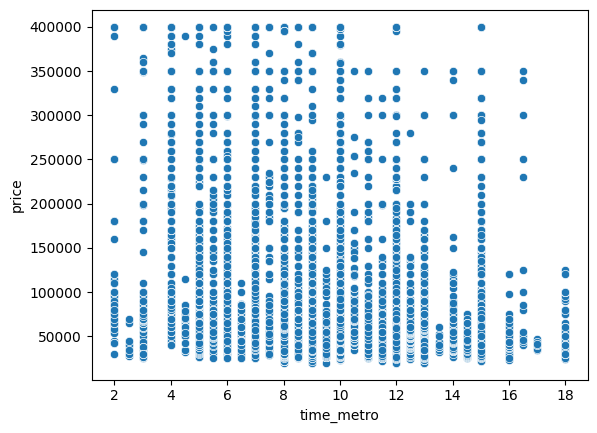

In [58]:
import seaborn as sns 
sns.scatterplot(data=df1, x='time_metro', y='price')

In [46]:
Q1 = df1['time_metro'].quantile(0.25)
Q3 = df1['time_metro'].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[(df1['time_metro'] >= Q1 - 1.5 * IQR) & (df1['time_metro'] <= Q3 + 1.5 * IQR)]

In [47]:
df1.shape

(19240, 20)

<Axes: xlabel='price', ylabel='distance_to_moscow'>

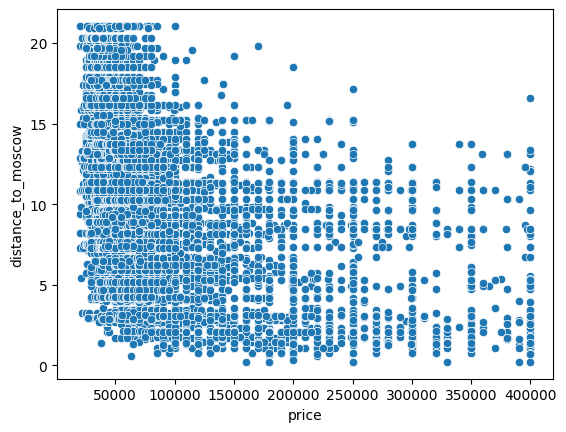

In [57]:
import seaborn as sns 
sns.scatterplot(data=df1, x='price', y='distance_to_moscow')

In [49]:
Q1 = df1['distance_to_moscow'].quantile(0.25)
Q3 = df1['distance_to_moscow'].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[(df1['distance_to_moscow'] >= Q1 - 1.5 * IQR) & (df1['distance_to_moscow'] <= Q3 + 1.5 * IQR)]

<Axes: xlabel='price', ylabel='distance_to_moscow'>

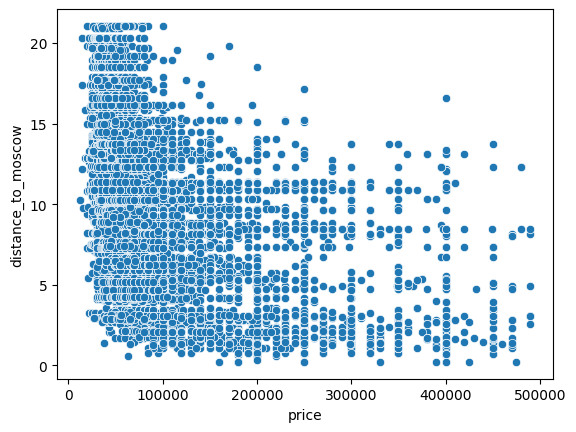

In [50]:
import seaborn as sns 
sns.scatterplot(data=df1, x='price', y='distance_to_moscow')

In [51]:


df1 = df1.loc[df1['price'].between(20_000, 400_000)]



In [55]:
df1.head()

,ID,parking,renovation,price,time_metro,total_area,house,rooms,combined_bath,separated_bath,passenger_elevator,freight_elevator,windows_to_the_courtyard,windows_to_the_street,windows_facing_the_street_and_yard,loggia,balcony_new,children_allowed,pets_allowed,distance_to_moscow
3,272197456,2,1,400000.00,7.00,170.00,1,4.00,3,0,1,0,0,0,1,0,0,0,1,2.33
4,273614615,0,1,225000.00,7.50,58.00,0,2.00,2,0,1,1,0,0,1,0,0,0,0,1.07
6,273643908,0,1,350000.00,7.50,213.00,1,5.00,2,0,1,0,0,0,1,0,0,1,1,1.07
7,274475342,2,1,250000.00,7.00,98.00,1,3.00,1,1,1,0,1,0,0,0,0,1,1,2.33
8,273973191,1,1,130000.00,7.00,120.00,1,3.00,1,0,1,0,0,1,0,0,0,0,1,2.33


In [56]:
df1.to_csv('bedolagi_data.csv', index=False)